In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Import datasets

In [5]:
train_df = r"train/"
test_df = r"test/"


### Data Pre-processing

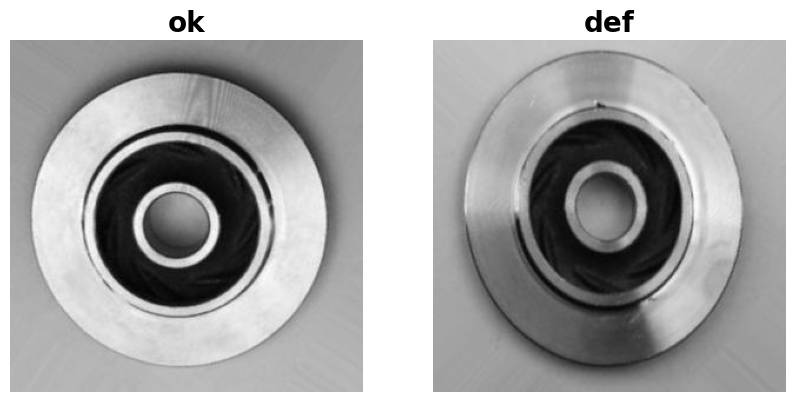

In [59]:
plt.figure(figsize=(10,8))
ok = plt.imread(train_df + 'ok_front/cast_ok_0_1.jpeg')
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title("ok", weight='bold', size=20)
plt.imshow(ok,cmap='gray')

ng = plt.imread(train_df + 'def_front/cast_def_0_1001.jpeg')
plt.subplot(1, 2, 2)
plt.axis('off')
plt.title("def", weight='bold', size=20)
plt.imshow(ng,cmap='gray')

plt.show()

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

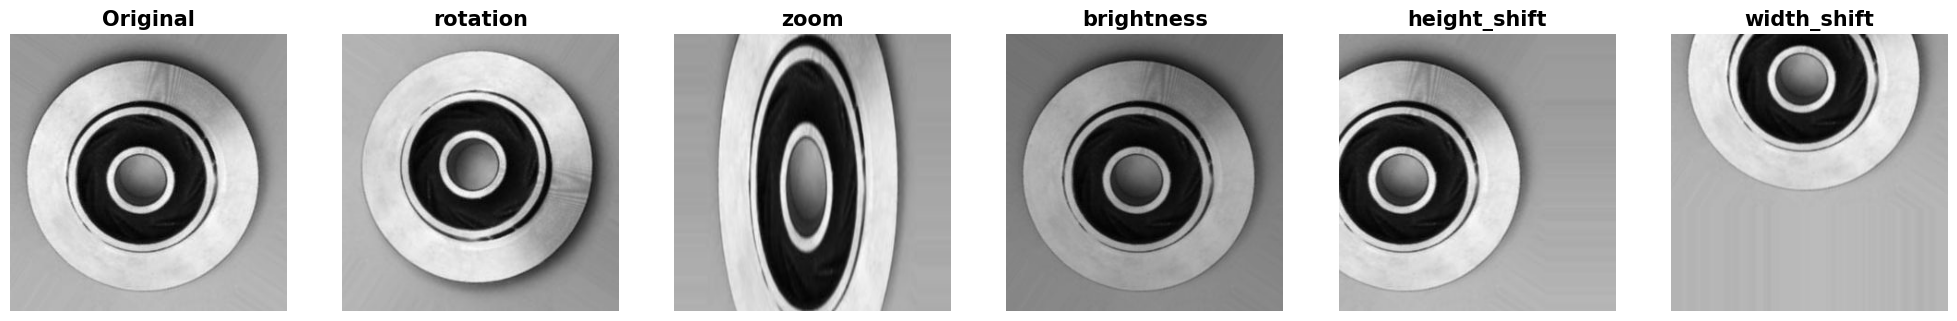

In [15]:
# Read the image and add an extra dimension for compatibility with the generator
img = cv2.imread(train_df + 'ok_front/cast_ok_0_1.jpeg')
img_4d = img[np.newaxis]

# Define various augmentations with ImageDataGenerator
generators = {
    "rotation": ImageDataGenerator(rotation_range=180),             # Rotate up to 180 degrees
    "zoom": ImageDataGenerator(zoom_range=0.7),                     # Zoom in on the image
    "brightness": ImageDataGenerator(brightness_range=[0.2, 1.0]),  # Adjust brightness range
    "height_shift": ImageDataGenerator(height_shift_range=0.7),     # Shift image vertically
    "width_shift": ImageDataGenerator(width_shift_range=0.7)        # Shift image horizontally
}

# Display the original image and the augmented versions
plt.figure(figsize=(25, 10))
plt.subplot(1, 6, 1)
plt.title("Original", weight='bold', size=15)
plt.imshow(img)
plt.axis('off')

# Loop through each augmentation and display results
cnt = 2
for param, generator in generators.items():
    gen = generator.flow(img_4d, batch_size=1)
    g_img = next(gen)[0].astype(np.uint8)    # Generate augmented image and convert to display format

    plt.subplot(1, 6, cnt)
    plt.title(param, weight='bold', size=15)
    plt.imshow(g_img)
    plt.axis('off')
    cnt += 1
plt.show()


In [17]:
# Normalize pixel values to [0,1] range by scaling down from [0,255]
# Adjust brightness, keeping it close to original (90% - 100%)
image_gen = ImageDataGenerator(rescale=1/255,zoom_range=0.1, brightness_range=[0.9, 1.0])


In [19]:
# Define image shape and batch size for training/testing
image_shape = (300, 300, 1)
batch_size = 32

In [23]:
# Generate the training set with data augmentation and preprocessing
train_set = image_gen.flow_from_directory(
    train_df, target_size=image_shape[:2],color_mode="grayscale", classes={'def_front': 0, 'ok_front': 1},
    batch_size=batch_size, class_mode='binary',
    shuffle=True,
    seed=0)

Found 6633 images belonging to 2 classes.


In [27]:
# Generate the test set with data preprocessing (no shuffling or augmentation)
test_set = image_gen.flow_from_directory(
    test_df, target_size=image_shape[:2],color_mode="grayscale", classes={'def_front': 0, 'ok_front': 1},
    batch_size=batch_size, class_mode='binary',
    shuffle=False,
    seed=0)

Found 715 images belonging to 2 classes.


In [29]:
train_set.class_indices

{'def_front': 0, 'ok_front': 1}

### Model training

In [34]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend

In [36]:
backend.clear_session()  # Clear previous model session to free memory

# Initialize a sequential model
model = Sequential()

# First convolutional block with Conv2D and MaxPooling2D layers
model.add(Conv2D(filters=16, kernel_size=(7,7), strides=2, input_shape=image_shape, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

# Flatten the feature map for input to the dense layers
model.add(Flatten())

# Fully connected dense layer
model.add(Dense(units=224, activation='relu'))
model.add(Dropout(rate=0.2))  # Dropout layer for regularization

# Output layer with sigmoid activation for binary classification
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model with binary crossentropy loss and accuracy metric
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 16)        │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 224)                 │       4,645,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 224)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             225 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,669,249 (17.81 MB)

 Trainable params: 4,669,249 (17.81 MB)

 Non-trainable params: 0 (0.00 B)

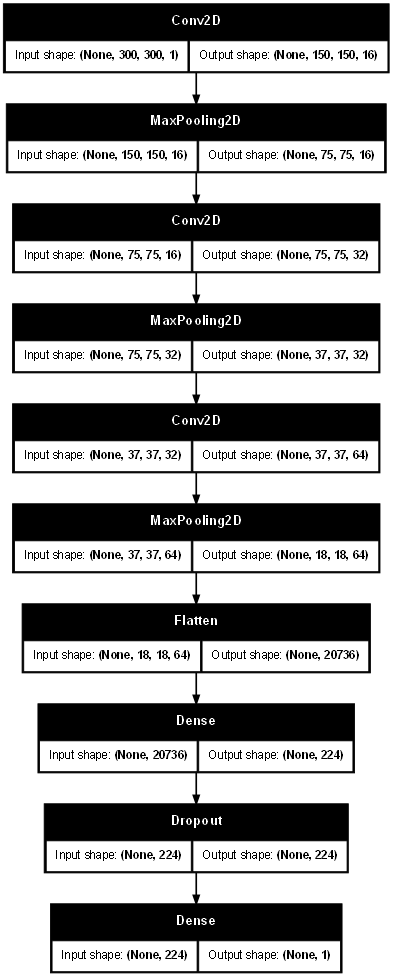

In [40]:
plot_model(model, show_shapes=True, expand_nested=True, dpi=60)

In [47]:
model_save_path = 'defect_classification.keras'

# EarlyStopping callback to stop training when the validation loss doesn't improve
early_stop = EarlyStopping(monitor='val_loss', patience=2)  

# ModelCheckpoint callback to save the best model based on validation loss
checkpoint = ModelCheckpoint(filepath=model_save_path, verbose=1, save_best_only=True, monitor='val_loss')


In [51]:
n_epochs = 20
results = model.fit(
    train_set, epochs=n_epochs, validation_data=test_set, callbacks=[early_stop, checkpoint]
)


Epoch 1/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.6089 - loss: 0.6752
Epoch 1: val_loss improved from inf to 0.29798, saving model to defect_classification.keras
208/208 ━━━━━━━━━━━━━━━━━━━━ 116s 495ms/step - accuracy: 0.6093 - loss: 0.6746 - val_accuracy: 0.8601 - val_loss: 0.2980
Epoch 2/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.8654 - loss: 0.3173
Epoch 2: val_loss improved from 0.29798 to 0.19753, saving model to defect_classification.keras
208/208 ━━━━━━━━━━━━━━━━━━━━ 54s 256ms/step - accuracy: 0.8654 - loss: 0.3173 - val_accuracy: 0.9147 - val_loss: 0.1975
Epoch 3/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.9014 - loss: 0.2261
Epoch 3: val_loss did not improve from 0.19753
208/208 ━━━━━━━━━━━━━━━━━━━━ 54s 254ms/step - accuracy: 0.9015 - loss: 0.2259 - val_accuracy: 0.9049 - val_loss: 0.1995
Epoch 4/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9458 - loss: 0.1394
Epoch 4: val_loss improved from 0.19753 to 0.16011, 

In [53]:
import json

# Save the training history as a dictionary of float values
model_history = {i: list(map(lambda x: float(x), j)) for i, j in results.history.items()}

# Write the history to a JSON file
with open('model_history.json', 'w') as f:
    json.dump(model_history, f, indent=4)


In [55]:
with open('model_history.json', 'r') as f:
    saved_history = json.load(f)
    print(saved_history)


{'accuracy': [0.6953113079071045, 0.872606635093689, 0.9219056367874146, 0.9505502581596375, 0.9660786986351013, 0.9775365591049194, 0.9791949391365051, 0.9846223592758179, 0.9862807393074036, 0.9900497794151306, 0.9891451597213745, 0.9886928796768188], 'loss': [0.5606154203414917, 0.300994873046875, 0.18616554141044617, 0.13037212193012238, 0.0966060608625412, 0.07048343867063522, 0.06441004574298859, 0.04761841893196106, 0.04077468067407608, 0.03419755399227142, 0.03375978767871857, 0.030220894142985344], 'val_accuracy': [0.8601398468017578, 0.9146853089332581, 0.9048951268196106, 0.9258741140365601, 0.9482517242431641, 0.9790209531784058, 0.9622377753257751, 0.9748252034187317, 0.9944055676460266, 0.9958041906356812, 0.988811194896698, 0.9902098178863525], 'val_loss': [0.2979784309864044, 0.19753222167491913, 0.1994972974061966, 0.16011261940002441, 0.11491834372282028, 0.06752155721187592, 0.09912711381912231, 0.06131457909941673, 0.02107718214392662, 0.019034994766116142, 0.029592

### Model Performance

In [60]:
losses = pd.DataFrame(saved_history)
losses.index = map(lambda x : x+1, losses.index)
losses.head(5)

,accuracy,loss,val_accuracy,val_loss
1,0.695311,0.560615,0.860140,0.297978
2,0.872607,0.300995,0.914685,0.197532
3,0.921906,0.186166,0.904895,0.199497
4,0.950550,0.130372,0.925874,0.160113
5,0.966079,0.096606,0.948252,0.114918


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
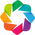

In [62]:
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')

In [64]:
# Assuming 'losses' is a dictionary containing the history of training and validation loss and accuracy
evaluation_plot = hv.Curve(losses['loss'], label='Training Loss') * \
                  hv.Curve(losses['val_loss'], label='Validation Loss') * \
                  hv.Curve(losses['accuracy'], label='Training Accuracy') * \
                  hv.Curve(losses['val_accuracy'], label='Validation Accuracy')

# Apply options for visualization
evaluation_plot.opts(
    opts.Curve(
        xlabel="Epochs",
        ylabel="Loss / Accuracy",
        width=700,
        height=400,
        tools=['hover'],
        show_grid=True,
        title='Model Evaluation'
    )
).opts(legend_position='bottom')  # Position the legend at the bottom

:Overlay
   .Curve.Training_Loss       :Curve   [index]   (loss)
   .Curve.Validation_Loss     :Curve   [index]   (val_loss)
   .Curve.Training_Accuracy   :Curve   [index]   (accuracy)
   .Curve.Validation_Accuracy :Curve   [index]   (val_accuracy)

### Metric Classification

In [67]:
from sklearn.metrics import confusion_matrix, classification_report

23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step


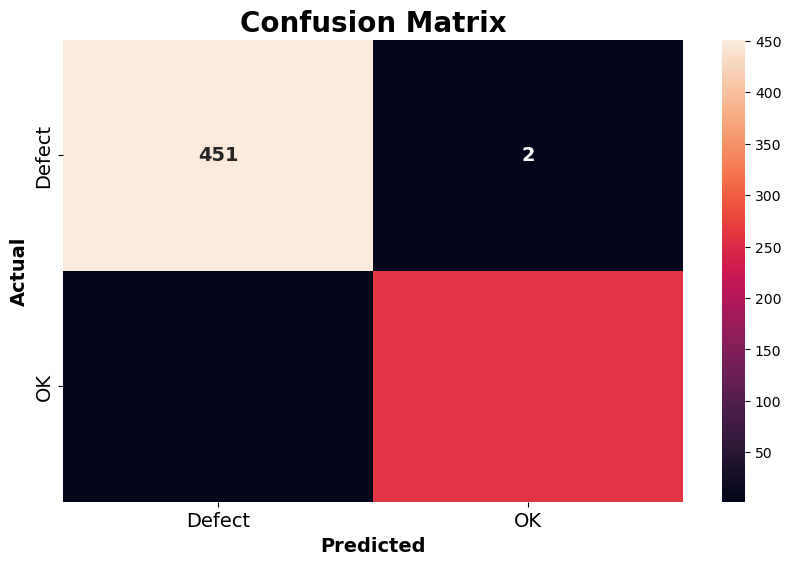

In [71]:
pred_probability = model.predict(test_set)
predictions = pred_probability > 0.5

plt.figure(figsize=(10,6))
plt.title("Confusion Matrix", size=20, weight='bold')
sns.heatmap(
    confusion_matrix(test_set.classes, predictions),
    annot=True,
    annot_kws={'size':14, 'weight':'bold'},
    fmt='d',
    xticklabels=['Defect', 'OK'],
    yticklabels=['Defect', 'OK'])
plt.tick_params(axis='both', labelsize=14)
plt.ylabel('Actual', size=14, weight='bold')
plt.xlabel('Predicted', size=14, weight='bold')
plt.show()

In [75]:
print(confusion_matrix(test_set.classes, predictions))

[[451   2]
 [  2 260]]


In [81]:
print(classification_report(test_set.classes, predictions, digits=3))

              precision    recall  f1-score   support

           0      0.996     0.996     0.996       453
           1      0.992     0.992     0.992       262

    accuracy                          0.994       715
   macro avg      0.994     0.994     0.994       715
weighted avg      0.994     0.994     0.994       715



### Classify Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


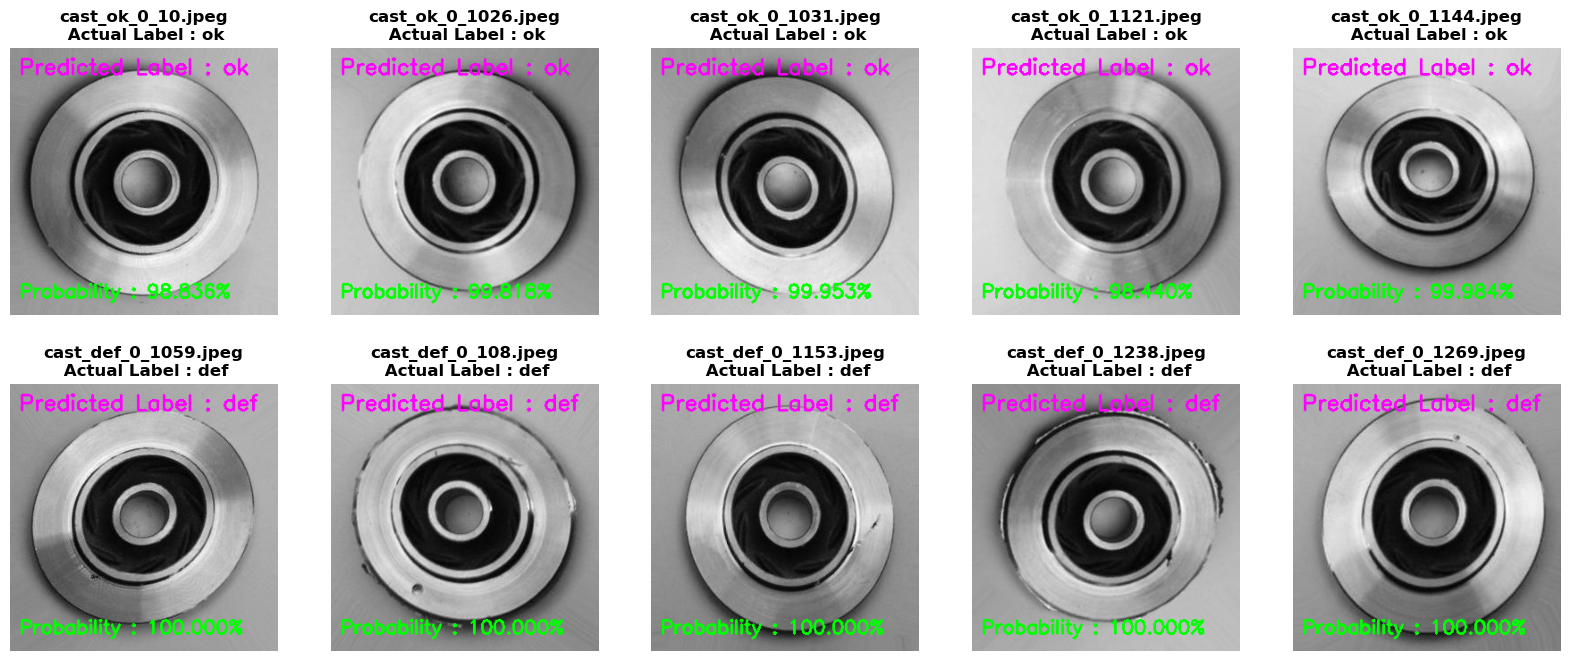

In [86]:
test_cases = ['ok_front/cast_ok_0_10.jpeg', 'ok_front/cast_ok_0_1026.jpeg', 'ok_front/cast_ok_0_1031.jpeg', 'ok_front/cast_ok_0_1121.jpeg', \
              'ok_front/cast_ok_0_1144.jpeg','def_front/cast_def_0_1059.jpeg', 'def_front/cast_def_0_108.jpeg', 'def_front/cast_def_0_1153.jpeg',\
              'def_front/cast_def_0_1238.jpeg', 'def_front/cast_def_0_1269.jpeg']

plt.figure(figsize=(20,8))
for i in range(len(test_cases)):
    img_pred = cv2.imread(test_df + test_cases[i], cv2.IMREAD_GRAYSCALE)
    img_pred = img_pred / 255 # rescale
    prediction = model.predict(img_pred.reshape(1, *image_shape))
    
    img = cv2.imread(test_df + test_cases[i])
    label = test_cases[i].split("_")[0]
    
    plt.subplot(2, 5, i+1)
    plt.title(f"{test_cases[i].split('/')[1]}\n Actual Label : {label}", weight='bold', size=12)
    # Predicted Class : defect
    if (prediction < 0.5):
        predicted_label = "def"
        prob = (1-prediction.sum()) * 100
    # Predicted Class : OK
    else:
        predicted_label = "ok"
        prob = prediction.sum() * 100
        
    cv2.putText(img=img, text=f"Predicted Label : {predicted_label}", org=(10, 30), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8, color=(255, 0, 255), thickness=2)
    cv2.putText(img=img, text=f"Probability : {'{:.3f}'.format(prob)}%", org=(10, 280), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.7, color=(0, 255, 0), thickness=2)
    plt.imshow(img,cmap='gray')
    plt.axis('off')

plt.show()

### Misclassified Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

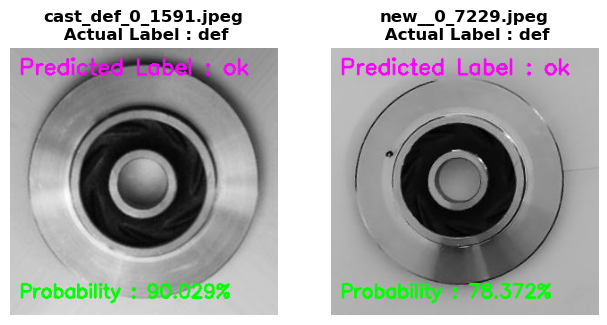

In [89]:
import os
import cv2
import matplotlib.pyplot as plt

# Define your local directories for test images
train_df = r"train/"
test_df = r"test/"

# Create test_cases list by listing files in respective directories
test_cases = ['ok_front/' + i for i in os.listdir(f'{test_df}/ok_front')]
test_cases.extend(['def_front/' + i for i in os.listdir(f'{test_df}/def_front')])

plt.figure(figsize=(20,8))
cnt = 0
misclassified = []

# Loop over the test cases and display predictions
for i in range(len(test_cases)):
    if cnt == 10:
        break  # Show max 10 images
    img_pred = cv2.imread(test_df + '/' + test_cases[i], cv2.IMREAD_GRAYSCALE)
    try:
        img_pred = img_pred / 255  # Rescale image
    except:
        continue  # Skip if there is an issue with the image

    prediction = model.predict(img_pred.reshape(1, *image_shape))  # Make prediction
    
    # Read the image for visualization
    img = cv2.imread(test_df + '/' + test_cases[i])
    label = test_cases[i].split("_")[0]  # Extract actual label (def or ok)
    
    # Predicted Class : defect
    if prediction < 0.5:
        predicted_label = "def"
        prob = (1 - prediction.sum()) * 100
    # Predicted Class : OK
    else:
        predicted_label = "ok"
        prob = prediction.sum() * 100
    
    # If the prediction is wrong, add to misclassified list and display
    if label != predicted_label:
        misclassified.append(test_cases[i])
        plt.subplot(2, 5, cnt+1)
        plt.title(f"{test_cases[i].split('/')[1]}\n Actual Label : {label}", weight='bold', size=12)
        
        # Annotate image with predicted label and probability
        cv2.putText(img=img, text=f"Predicted Label : {predicted_label}", org=(10, 30), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8, color=(255, 0, 255), thickness=2)
        cv2.putText(img=img, text=f"Probability : {'{:.3f}'.format(prob)}%", org=(10, 280), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.7, color=(0, 255, 0), thickness=2)
        
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        cnt += 1
    else:
        continue  # Skip if correctly classified

plt.show()


### Model  Interpretation

In [94]:
import shap
from operator import itemgetter

In [98]:
train_cases = ['ok_front/' + i for i in os.listdir(f'{train_df}/ok_front')]
train_cases.extend(['def_front/' + i for i in os.listdir(f'{train_df}/def_front')])

# Randomly sample 3000 images from the train dataset, reshape and normalize
train_sample = [cv2.imread(train_df + '/' + i, cv2.IMREAD_GRAYSCALE).reshape(1, *image_shape) / 255 for i in np.random.choice(train_cases, 3000, replace=False)]

# Initialize SHAP DeepExplainer with the first sample
explainer = shap.DeepExplainer(model, train_sample[0])

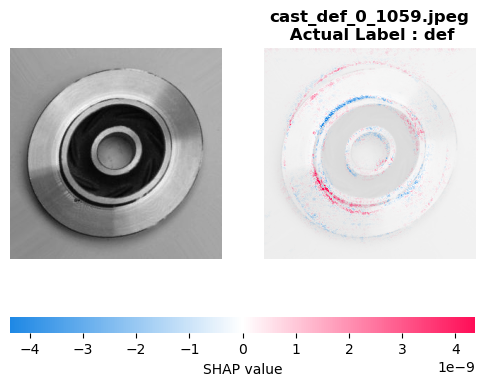

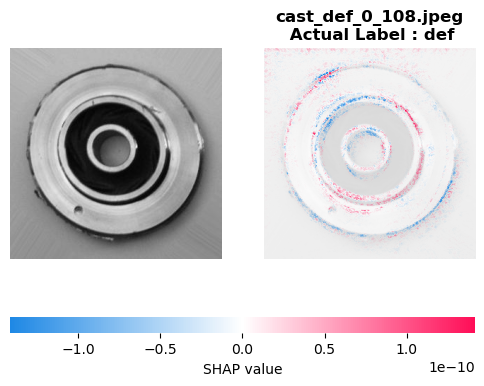

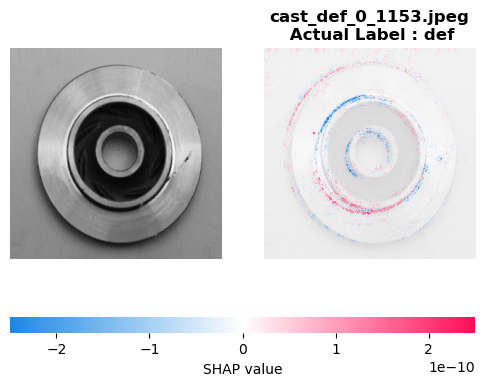

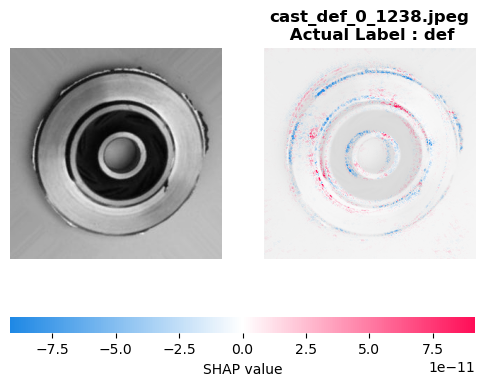

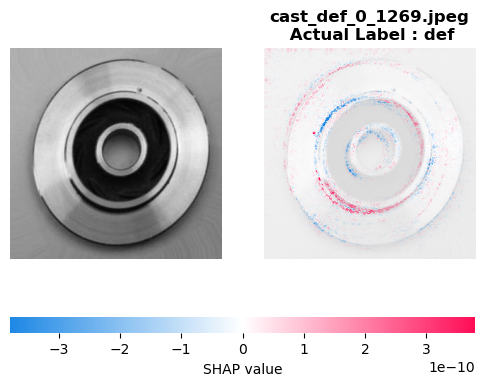

In [100]:
test_cases = ['def_front/cast_def_0_1059.jpeg', 'def_front/cast_def_0_108.jpeg', 'def_front/cast_def_0_1153.jpeg',\
              'def_front/cast_def_0_1238.jpeg', 'def_front/cast_def_0_1269.jpeg']

for i in test_cases:
    img = cv2.imread(test_df + i, cv2.IMREAD_GRAYSCALE).reshape(1, *image_shape) / 255
    shap_values = explainer.shap_values(img)
    shap.image_plot(shap_values, img, show=False) 
    plt.title(f"{i.split('/')[1]}\n Actual Label : {i.split('_')[0]}", weight='bold', size=12)
    plt.axis('off')
plt.show()

### Misclassified Images

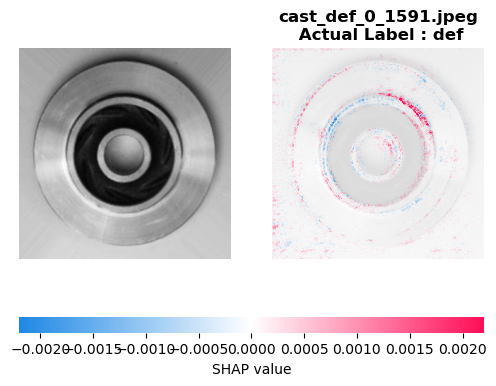

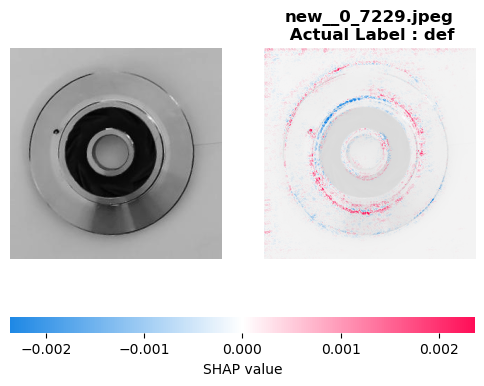

In [103]:
for i in misclassified:
    img = cv2.imread(test_df + i, cv2.IMREAD_GRAYSCALE).reshape(1, *image_shape) / 255
    shap_values = explainer.shap_values(img)
    shap.image_plot(shap_values, img, show=False) 
    plt.title(f"{i.split('/')[1]}\n Actual Label : {i.split('_')[0]}", weight='bold', size=12)
    plt.axis('off')
plt.show()